# Breast cancer image classification
**INSTITUTO FEDERAL DE MINAS GERIAS**
*Departamento de Engenharia e Computação*

**Professor:** Natalia C. do Carmo

**Alunos:** Antonio Ambrosio, Euler Gomes e Miguel Fellipe

**Dataset from:** https://zenodo.org/records/14769221


# 1. Ambient preparation

In [1]:
from IPython.display import display, HTML
from babel.util import missing

display(HTML("<style>.container {widht: 100% !important;}</style>"))

## 1.1. Import packages

In [2]:
import subprocess
import sys

import os
import shutil
import random
from pathlib import Path
import pygame
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import classification_report, confusion_matrix

C:\Users\euler\miniconda3\envs\torch\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.11.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


## 1.2. GPU check

In [3]:
if torch.cuda.is_available():
    print("__CUDNN VERSION:", torch.backends.cudnn.version())
    print("Device Name:", torch.cuda.get_device_name(0))
    device = 'cuda'
else:
    print("CUDA is not available.")
    device = 'cpu'

print('Device:', device)

__CUDNN VERSION: 91200
Device Name: NVIDIA GeForce RTX 5070
Device: cuda


## 1.3. Export requirements.txt

In [4]:
def export_requirements():
    try:
        result = subprocess.run([sys.executable, "-m", "pip", "freeze"],
                                capture_output=True,
                                text=True,
                                check=True)
        with open('requirements.txt', 'w') as f:
            f.write(result.stdout)
        print('requirements.txt file generated sucessfully.')
    except subprocess.CalledProcessError as e:
        print('error:', e)


export_requirements()

requirements.txt file generated sucessfully.


# 2. Load dataset

## 2.1. Split dataset

In [5]:
new_split = False  #if equals False doesn't make a new split

#dataset path
data_og = "data_og"
data_split = 'data_split'

#split ratio
# train + val + test == 1.0
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

In [6]:
if new_split:
    #create dir
    for split in ["train", "val", "test"]:
        for cls in os.listdir(data_og):
            Path(f"{data_split}/{split}/{cls}").mkdir(parents=True, exist_ok=True)

    #split per class
    for cls in os.listdir(data_og):
        class_path = os.path.join(data_og, cls)
        images = os.listdir(class_path)

        random.shuffle(images)

        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)

        train_images = images[:n_train]
        val_images = images[n_train:n_train + n_val]
        test_images = images[n_train + n_val:]


        def copy_images(img_list, split_name):
            for img in img_list:
                src = os.path.join(class_path, img)
                dst = os.path.join(data_split, split_name, cls, img)
                shutil.copy2(src, dst)


        copy_images(train_images, "train")
        copy_images(val_images, "val")
        copy_images(test_images, "test")

        print(f"Class '{cls}': {n_train} train | {n_val} val | {len(test_images)} test")


## 2.1. Pre-processing

In [7]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

## 2.2. Load dataset to pytorch

In [8]:
train_dataset = ImageFolder("data_split/train", transform=transform_train)
val_dataset = ImageFolder("data_split/val", transform=transform_test)
test_dataset = ImageFolder("data_split/test", transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

## 2.3 Data visualization

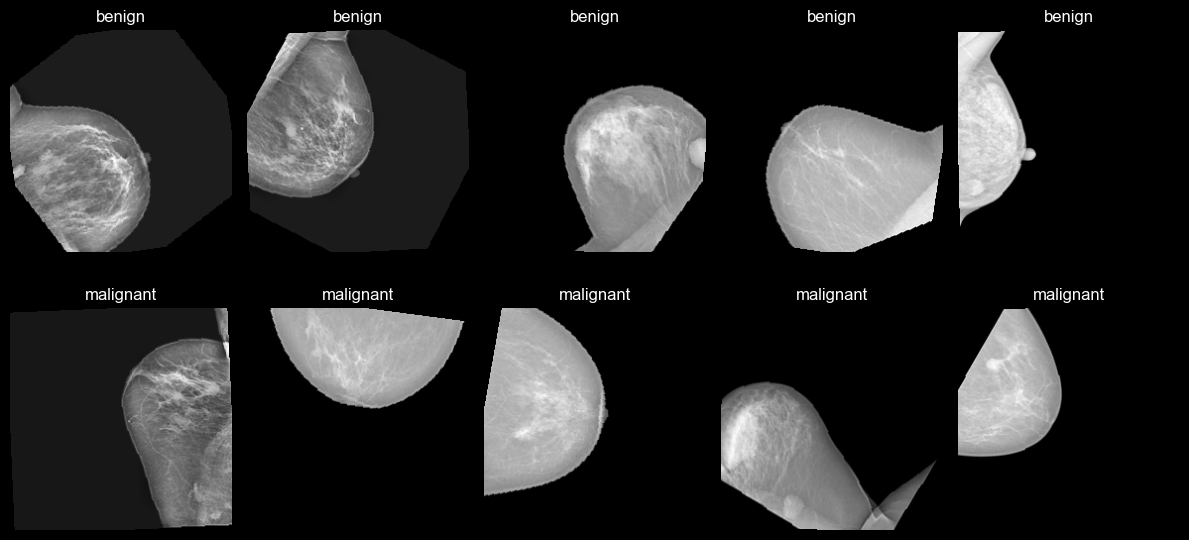

In [9]:
all_targets = np.array(train_dataset.targets)
class_names = ['benign', 'malignant']

fig, axs = plt.subplots(2, 5, figsize=(12, 6))

for i, class_name in enumerate(class_names):
    class_indices = np.where(all_targets == i)[0]
    sample_indices = np.random.choice(class_indices, min(5, len(class_indices)), replace=False)

    for j, idx in enumerate(sample_indices):
        img_tensor = train_dataset[idx][0]
        img_display = img_tensor.permute(1, 2, 0).numpy()
        img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())

        axs[i, j].imshow(img_display, cmap='gray')
        axs[i, j].set_title(f'{class_name}')
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

# 3. Model training

## 3.1. Model class definition

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  #3 color channels / 32 filters / 3x3 filter size
            nn.ReLU(),  #activation function
            nn.MaxPool2d(2),  #1/2 * image size

            nn.Conv2d(32, 64, 3, padding=1),  #3 color channels / 64 filters / 3x3 filter size
            nn.ReLU(),  #activation function
            nn.MaxPool2d(2),  #1/2 * image size
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),  #flatten the 3D feature maps to one vector
            nn.Linear(64 * 56 * 56, 128),  #full connected layer
            nn.ReLU(),  #activation function
            nn.Linear(128, 2)  #belign / malignant
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

## 3.2. Model parameter

In [22]:
learning_rate = 0.001
max_epochs = 100

new_model = True
save_model = True

model = CNN()  #new instance of model
if new_model:
    model.to(device)
elif not new_model:
    model.load_state_dict(torch.load("models/model_breast_cancer.pth"))
    model.eval()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
#info about model
summary(
    model,
    input_size=(1, 3, 224, 224),
    col_names=("input_size", "output_size", "num_params", "kernel_size"),
    depth=3
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
CNN                                      [1, 3, 224, 224]          [1, 2]                    --                        --
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 64, 56, 56]           --                        --
│    └─Conv2d: 2-1                       [1, 3, 224, 224]          [1, 32, 224, 224]         896                       [3, 3]
│    └─ReLU: 2-2                         [1, 32, 224, 224]         [1, 32, 224, 224]         --                        --
│    └─MaxPool2d: 2-3                    [1, 32, 224, 224]         [1, 32, 112, 112]         --                        2
│    └─Conv2d: 2-4                       [1, 32, 112, 112]         [1, 64, 112, 112]         18,496                    [3, 3]
│    └─ReLU: 2-5                         [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --
│    └─

## 3.3. Training

In [24]:
if new_model:
    model.train()
    for epoch in range(max_epochs):
        train_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1} - Train loss: {loss.item():.4f}")
if save_model:
    os.makedirs('models', exist_ok=True)
    torch.save(model.state_dict(), "models/model_breast_cancer.pth")


Epoch 1/10 - Train loss: 0.0000
Epoch 2/10 - Train loss: 0.0000
Epoch 3/10 - Train loss: 0.0000
Epoch 4/10 - Train loss: 0.0000
Epoch 5/10 - Train loss: 0.0000
Epoch 6/10 - Train loss: 0.0000
Epoch 7/10 - Train loss: 0.0000
Epoch 8/10 - Train loss: 0.0000
Epoch 9/10 - Train loss: 0.0000
Epoch 10/10 - Train loss: 0.0000


In [26]:
pygame.mixer.init()
success_audio = 'support_files/mario_coin.mp3'
pygame.mixer.music.load(success_audio)
pygame.mixer.music.play()

while pygame.mixer.music.get_busy():
    continue

print('Success!')

Success!


# 4. Validation

In [27]:
model.eval()  #model to evaluation mode

#cont
val_loss = 0
correct = 0
total = 0

with torch.no_grad():  #no gradient
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)  #error calc

        #accuracy calc
        val_loss += loss.item()
        pred = torch.argmax(outputs, dim=1)
        correct += torch.sum(pred == labels).sum().item()
        total += labels.size(0)

val_acc = correct / total

print(f'Validation loss: {val_loss / len(val_loader):.4f}')
print(f'Validation accuracy: {val_acc:.4f}')

Validation loss: 0.3254
Validation accuracy: 0.8400


# 5. Test

In [28]:
y_hat = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        pred = torch.argmax(outputs, dim=1)

        y_true.extend(labels.numpy())
        y_hat.extend(pred.cpu().numpy())

print(*y_hat)

0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 

## 5.1. Test evaluation

In [29]:
print(classification_report(
    y_true,
    y_hat,
    target_names=["Benign", "Malignant"]
))

              precision    recall  f1-score   support

      Benign       0.78      0.80      0.79       253
   Malignant       0.90      0.89      0.89       512

    accuracy                           0.86       765
   macro avg       0.84      0.84      0.84       765
weighted avg       0.86      0.86      0.86       765



## 5.2. Confusion matrix

In [ ]:
cm = confusion_matrix(y_true, y_hat)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=["Benign", "Malignant"],
    yticklabels=["Benign", "Malignant"],
)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()